In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount= True)
%cd /content/gdrive/MyDrive/SSDSResearchSP21

import os
import random
import torch
import torch.utils.data
from torchvision import transforms
from torchvision import models
from PIL import Image
from skimage import feature
import numpy as np
import torch.utils.data as data
import matplotlib.pyplot as plt

Mounted at /content/gdrive
/content/gdrive/MyDrive/SSDSResearchSP21


In [ ]:
from models import Glow

# Set the device and load the most recent network
device = 'cuda' if torch.cuda.is_available() and [0] else 'cpu'
net = Glow(num_channels=128, num_levels=3, num_steps=16, mode='multi', cond_channels = 20, coupling16=True)
net = net.to(device)
if device == 'cuda':
  net = torch.nn.DataParallel(net, [0])

checkpoint = torch.load('ckpts/all/199.pth.tar')
state_dict = checkpoint['net']
net.load_state_dict(state_dict)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


<All keys matched successfully>

In [ ]:
from data.dataset import ImgDatasets_static
testset = ImgDatasets_static(root_dir='dotaDset_interpolate', files='dota_test_files.txt', mode= 'multi', from_file = True, train_set = False, fraction_num = 0, tight = True)

In [ ]:
import util

testloader = data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=1)

#bpd_list = [[],[],[],[],[],[],[],[],[]]
bpd_list = [[],[],[]]
loss_fn = util.NLLLoss().to(device)


net.train()
for x, cond_x in testloader:

  input = cond_x.cpu().detach()
  input = np.asarray(input)
  NIIRS_output, NIIRS_input = input[:,3,0,0]*9, input[:,4,0,0]*9
  NIIRS_dif = int(NIIRS_output - NIIRS_input)
  #NIIRS_dif = int(NIIRS_output - NIIRS_input)+4
  #print(NIIRS_dif)

  x , cond_x= x.to(device), cond_x.to(device)
  z, sldj = net(x, cond_x, reverse=False)
  loss = loss_fn(z, sldj).item()
  bpd = util.bits_per_dim(x, loss)

  bpd_list[NIIRS_dif].append(bpd)

          

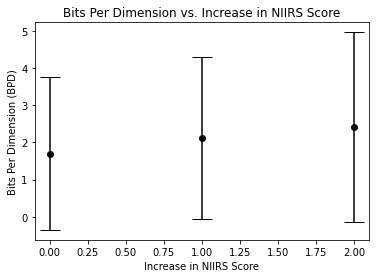

In [ ]:
means = []
stds = []
for bpd in bpd_list:
  means.append(np.mean(bpd))
  stds.append(np.std(bpd))

fig = plt.figure()
ax = fig.add_subplot()
plt.scatter(x = np.arange(0,3), y = means, color = 'black')
plt.errorbar(x = np.arange(0,3), y = means, yerr = stds, color ='black', ls = 'none', capsize= 10)
#plt.scatter(x = np.arange(-4,5), y = means, color = 'black')
#plt.errorbar(x = np.arange(-4,5), y = means, yerr = stds, color ='black', ls = 'none', capsize= 10)
ax.title.set_text('Bits Per Dimension vs. Increase in NIIRS Score')
ax.xaxis.set_label_text('Increase in NIIRS Score')
ax.yaxis.set_label_text('Bits Per Dimension (BPD)')

fig.savefig('paper_plots/bpd_plot.png')

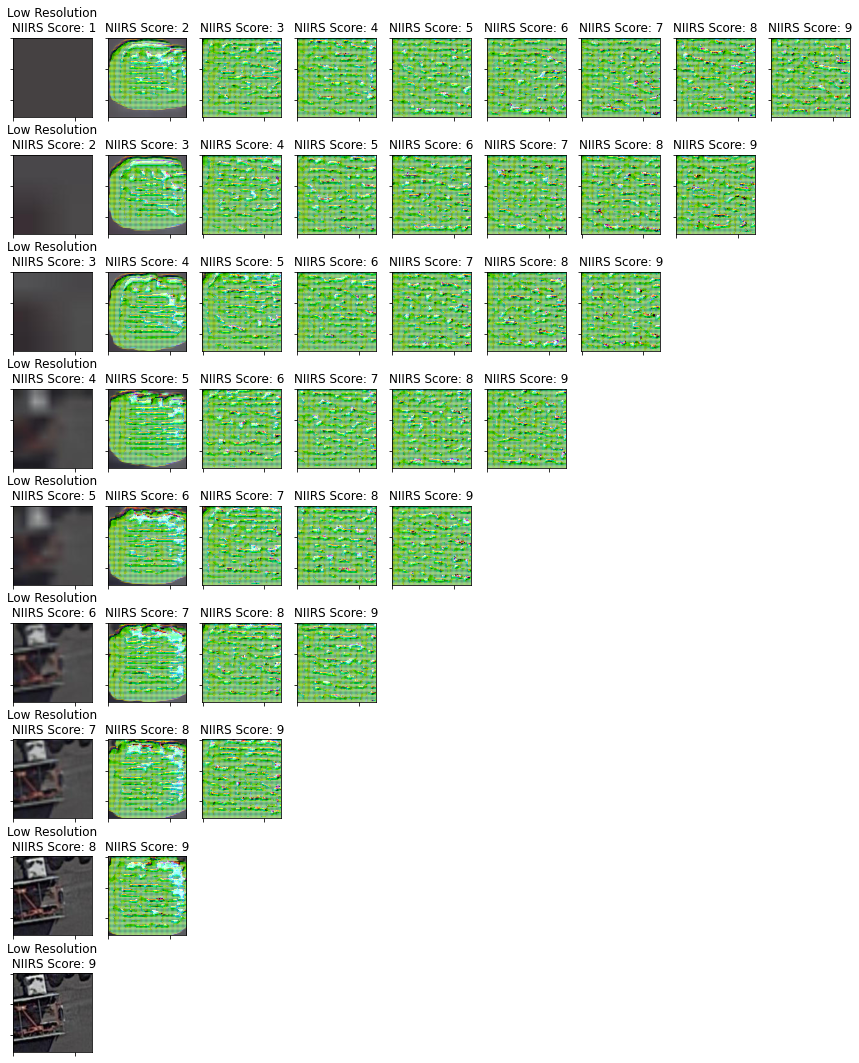

In [ ]:
Crop = transforms.CenterCrop(size = 128)
root_dir = 'dotaDset_interpolate/P1818_5'
net.eval()

fig = plt.figure(figsize=(15, 19))
n = 1
for i in range(1,10):
  x = Image.open(os.path.join(root_dir, str(i)+'.jpg'))
  x = Crop(x)
  x = np.asarray(x).astype('float32')/256
  x = np.transpose(x, (2, 0, 1))
  x = torch.unsqueeze(torch.from_numpy(x), 0)

  origin = x.cpu().detach()
  origin = np.asarray(origin)

  ax = fig.add_subplot(9, 9, n)
  plt.imshow(np.transpose(origin[0], (1,2,0)))
  ax.title.set_text("Low Resolution\n NIIRS Score: " + str(i))
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  n+=1
  
  for j in range(i+1,10):
    cond_x = Image.open(os.path.join(root_dir, str(i)+'.jpg'))
    cond_x = Crop(cond_x)
    cond_x = np.asarray(cond_x).astype('float32')/256
    cond_x = np.dstack((cond_x, np.full((128, 128), (i)/9)))
    cond_x = np.dstack((cond_x, np.full((128, 128), (j)/9)))
    cond_x = np.transpose(cond_x, (2, 0, 1)).astype('float32')
    cond_x = torch.unsqueeze(torch.from_numpy(cond_x), 0)

    B, C, W, H = cond_x.shape
    z = torch.randn((B, 3, W, H), dtype=torch.float32, device=device) * 0.6
    output, _ = net(z, cond_x, reverse=True)
    output = torch.sigmoid(output)

    output = output.cpu().detach()
    output = np.asarray(output)

    ax2 = fig.add_subplot(9, 9, n)
    plt.imshow(np.transpose(output[0], (1,2,0)))
    ax2.title.set_text("NIIRS Score: " + str(j))
    ax2.set_yticklabels([])
    ax2.set_xticklabels([])
    n+=1
  n = (9*i)+1
fig.savefig('paper_plots/incremental.png')

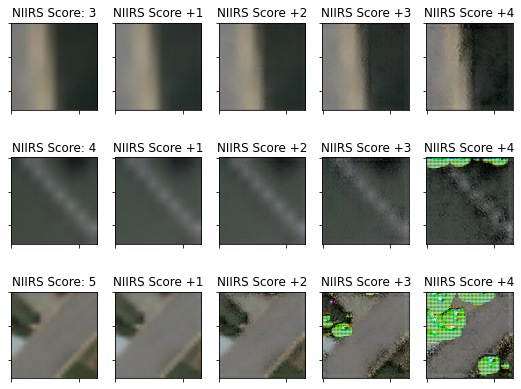

In [ ]:
testloader = data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=1)
net.eval()
fig = plt.figure(figsize=(9, 7))
n = 1
for i in range(3,6):
  score = 0
  x, cond_x = next(iter(testloader))

  while score != i:
    x, cond_x = next(iter(testloader))
    input = cond_x.cpu().detach()
    input = np.asarray(input)
    input, score = input[:,0:3,:,:], int(input[:,4,0,0]*9)

  ax = fig.add_subplot(3, 5, n)
  plt.imshow(np.transpose(input[0], (1,2,0)))
  ax.title.set_text("NIIRS Score: " + str(score))
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  n+=1

  for j in range(4):

    cond_x[:,3,:,:] = torch.from_numpy(np.ones((128,128), dtype= np.float32)*(score+j+1)/9)

    B, C, W, H = cond_x.shape
    z = torch.randn((B, 3, W, H), dtype=torch.float32, device=device) * 0.6
    output, _ = net(z, cond_x, reverse=True)
    output = torch.sigmoid(output)

    output = output.cpu().detach()
    output = np.asarray(output)

    ax = fig.add_subplot(3, 5, n)
    plt.imshow(np.transpose(output[0], (1,2,0)))
    ax.title.set_text("NIIRS Score +" + str(j+1))
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    n+=1
fig.savefig('paper_plots/IncreaseNIIRS')

In [ ]:
trainloader = data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=1)
x, cond_x = next(iter(trainloader))
net.eval()

B, C, W, H = cond_x.shape
z = torch.randn((B, 3, W, H), dtype=torch.float32, device=device) * 0.6
output, _ = net(z, cond_x, reverse=True)
output = torch.sigmoid(output)

output = output.cpu().detach()
output = np.asarray(output)
origin = x.cpu().detach()
origin = np.asarray(origin)
input = cond_x.cpu().detach()
input = np.asarray(input)
input, output_scores, input_scores = input[:,0:3,:,:], input[:,3,0,0]*9, input[:,4,0,0]*9

difs = output_scores-input_scores
num_sr = 0
for dif in difs:
  if dif > 0:
    num_sr += 1
print(num_sr)

fig = plt.figure(figsize=(7, 7.5))
n = 1
for i in range(np.shape(output)[0]):
  ax = fig.add_subplot(4, 4, n)
  plt.imshow(np.transpose(output[i], (1,2,0)))
  ax.title.set_text("NIIRS Score: " + str(output_scores[i]))
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  n+=1
fig.savefig('paper_plots/outputs.png')

In [ ]:
from data.dataset import ImgDatasets_static
trainset = ImgDatasets_static(root_dir='dotaDset_interpolate', files='dota_train_files.txt', mode= 'multi', from_file = True, train_set = True, fraction_num = 0)
trainloader = data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=1)

9


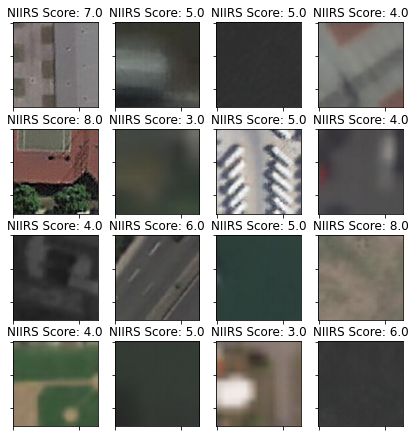

In [ ]:
x, cond_x = next(iter(trainloader))
net.eval()

B, C, W, H = cond_x.shape
z = torch.randn((B, 3, W, H), dtype=torch.float32, device=device) * 0.6
output, _ = net(z, cond_x, reverse=True)
output = torch.sigmoid(output)

output = output.cpu().detach()
output = np.asarray(output)
origin = x.cpu().detach()
origin = np.asarray(origin)
input = cond_x.cpu().detach()
input = np.asarray(input)
input, output_scores, input_scores = input[:,0:3,:,:], input[:,3,0,0]*9, input[:,4,0,0]*9

difs = output_scores-input_scores
num_sr = 0
for dif in difs:
  if dif > 0:
    num_sr += 1
print(num_sr)

fig = plt.figure(figsize=(7, 7.5))
n = 1
for i in range(np.shape(output)[0]):
  ax = fig.add_subplot(4, 4, n)
  plt.imshow(np.transpose(output[i], (1,2,0)))
  ax.title.set_text("NIIRS Score: " + str(output_scores[i]))
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  n+=1
fig.savefig('paper_plots/outputs.png')

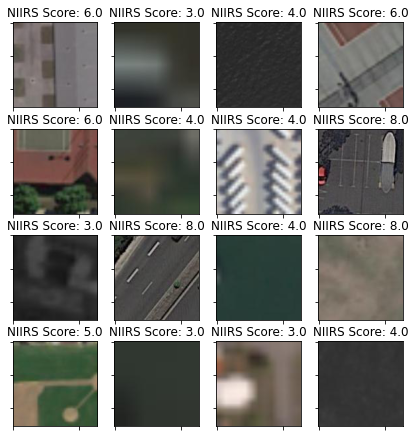

In [ ]:
fig = plt.figure(figsize=(7, 7.5))
n = 1
for i in range(np.shape(input)[0]):
  ax = fig.add_subplot(4, 4, n)
  plt.imshow(np.transpose(input[i], (1,2,0)))
  ax.title.set_text("NIIRS Score: " + str(input_scores[i]))
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  n+=1
fig.savefig('paper_plots/inputs.png')

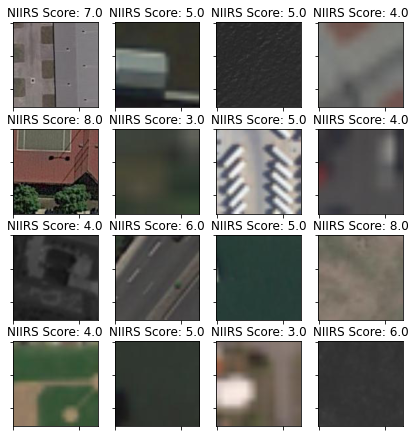

In [ ]:
fig = plt.figure(figsize=(7, 7.5))
n = 1
for i in range(np.shape(origin)[0]):
  ax = fig.add_subplot(4, 4, n)
  plt.imshow(np.transpose(origin[i], (1,2,0)))
  ax.title.set_text("NIIRS Score: " + str(output_scores[i]))
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  n+=1
fig.savefig('paper_plots/origin.png')

(13154, 2)
[ 3.906198 66.46881 ]


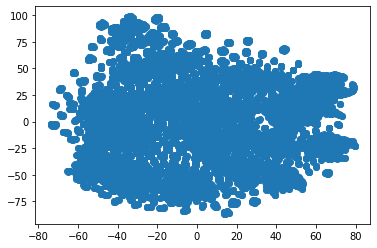

In [ ]:
tsne = np.load('tsne.npy')
print(np.shape(tsne))
print(tsne[0])
plt.scatter(tsne[:,0], tsne[:,1], cmap=['red', 'blue'])
# Unfinished